[I 2023-12-03 11:55:56,162] A new study created in memory with name: no-name-2b607a93-b740-40bc-91a4-649a6215702b
[I 2023-12-03 11:55:56,751] Trial 0 finished with value: -0.3958722681878286 and parameters: {'kernel': 'rbf', 'C': 121.93926314094409, 'epsilon': 0.38704808984163463, 'degree': 4, 'coef0': -0.01381097003782461}. Best is trial 0 with value: -0.3958722681878286.
[I 2023-12-03 11:55:57,101] Trial 1 finished with value: -369951.10461091093 and parameters: {'kernel': 'poly', 'C': 147.37665011529114, 'epsilon': 0.03466505372159321, 'degree': 3, 'coef0': -0.6086209913436751}. Best is trial 0 with value: -0.3958722681878286.
[I 2023-12-03 11:55:57,567] Trial 2 finished with value: -0.3590317945189676 and parameters: {'kernel': 'rbf', 'C': 28.20646484419417, 'epsilon': 0.4446842270395378, 'degree': 3, 'coef0': -0.9875246451002195}. Best is trial 2 with value: -0.3590317945189676.
[I 2023-12-03 11:55:57,857] Trial 3 finished with value: 0.06749539206903532 and parameters: {'kernel':

Best Parameters: {'kernel': 'rbf', 'C': 0.13256499647049394, 'epsilon': 0.019164323395197146, 'degree': 5, 'coef0': -0.7481199983066206}
Średni błąd kwadratowy (MSE): 124.84650247305572
Procentowa zgodność: 23.21%


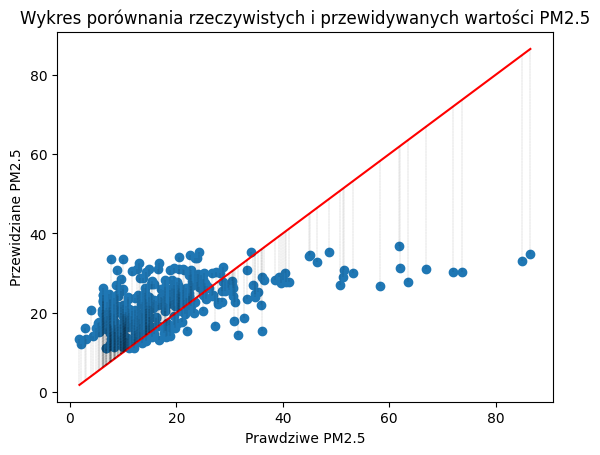

Średni błąd kwadratowy (MSE): 48.394197687700434
r2 score: -32.96%


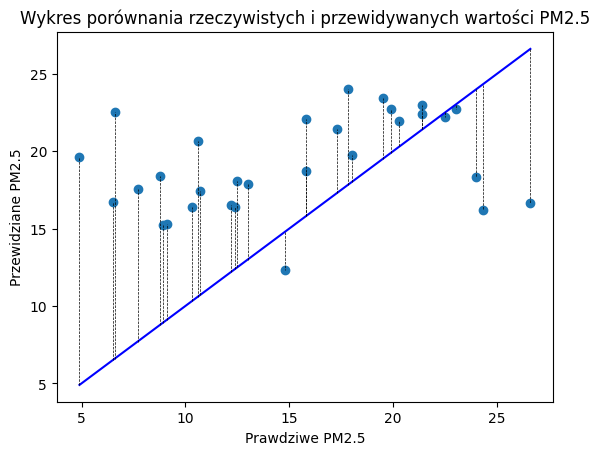

[I 2023-12-03 13:32:29,195] A new study created in memory with name: no-name-da6d8522-0cfd-4638-8293-8d160c05f680
[I 2023-12-03 13:32:36,064] Trial 0 finished with value: 0.8743523686743626 and parameters: {'kernel': 'poly', 'C': 58.269650465848464, 'epsilon': 0.2081210987169494, 'degree': 3, 'coef0': 0.3220873315137178}. Best is trial 0 with value: 0.8743523686743626.
[I 2023-12-03 13:32:41,982] Trial 1 finished with value: 0.8147713073850803 and parameters: {'kernel': 'poly', 'C': 65.39048099591938, 'epsilon': 0.43909381304873724, 'degree': 3, 'coef0': 0.028350052788065128}. Best is trial 0 with value: 0.8743523686743626.
[I 2023-12-03 13:32:43,663] Trial 2 finished with value: 0.8460936645561334 and parameters: {'kernel': 'rbf', 'C': 68.95954996844368, 'epsilon': 0.039023088552867, 'degree': 3, 'coef0': -0.804277139894555}. Best is trial 0 with value: 0.8743523686743626.
[I 2023-12-03 13:32:45,451] Trial 3 finished with value: 0.8459602497077274 and parameters: {'kernel': 'rbf', 'C'

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import optuna
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.patches as mpatches
import seaborn as sns



model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 200.0)
    epsilon = trial.suggest_float('epsilon', 0.001, 0.5)
    degree = trial.suggest_int('degree', 1, 5)  
    
    coef0 = trial.suggest_float('coef0', -1.0, 1.0)

    model = SVR(kernel=kernel, C=C, epsilon=epsilon,degree=degree,coef0=coef0)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize') 
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)



model = SVR(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)

y_pred_test = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test)
r2 = r2_score(y_test_test, y_pred_test)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'b', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()


model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 200.0)
    epsilon = trial.suggest_float('epsilon', 0.001, 0.5)
    degree = trial.suggest_int('degree', 1, 5)  
    
    coef0 = trial.suggest_float('coef0', -1.0, 1.0)

    model = SVR(kernel=kernel, C=C, epsilon=epsilon,degree=degree,coef0=coef0)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize') 
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)



model = SVR(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)


y_pred_test_2 = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test_2)
r2 = r2_score(y_test_test, y_pred_test_2)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)],'r', label='y=x')
plt.scatter(y_test_test, y_pred_test_2)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test_2[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

plt.figure(figsize=[16,8])
plt.plot(y_test_test,label="rzeczywiste")
plt.plot(y_pred_test,label="rok")
plt.plot(y_pred_test_2,label="tydzein")
plt.legend()
plt.show()

def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 13
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy rok): {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)



# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test_2
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()

procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): {procent_poprawnych:.2f}%")

plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy tydzień)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()